In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 불러오기

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv('/content/drive/MyDrive/2021-2 Text mining/ner_merge_data.csv', encoding='utf-16')
# 10.26. 새로 추가한 코드 - Nan 있는 행을 삭제하고 Index도 리셋시킴
data = data.dropna(axis=0)
data = data.reset_index(drop=True)
data = data.drop(['Unnamed: 0'], axis=1)

print("문장의 갯수: ", len(data))


# 훈련데이터에서 모든 문장별로 단어부분과 개체명 태깅정보를 분리하여 저장

sentences, labels = [], []

for i in range(len(data['text'])):
    a = data['text'].loc[i].split()
    sentences.append(a)

for i in range(len(data['label'])):
    b = data['label'].loc[i].split()
    labels.append(b)


# train_dataset = []
# for sen, label in zip(data['sentence'], data['word_labels']):
#   data_train = []
#   data_train.append(sen)
#   data_train.append(str(label))
#   train_dataset.append(data_train)

# labels[0]

문장의 갯수:  1237


In [ ]:
# 개체명 단어 리스트

word_labels_list = []

for i in range(len(data['label'])):
    b = data['label'].loc[i].split()
    word_labels_list.append(b)

word_labels_flat = [item for sublist in word_labels_list for item in sublist]

tag_values = list(set(word_labels_flat))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

# labels_to_ids = {k: v for v, k in enumerate(set(word_labels_flat))}
# ids_to_labels = {v: k for v, k in enumerate(set(word_labels_flat))}
# labels_to_ids

{'DAMAGE': 2, 'ELEMENT': 1, 'FACTOR': 0, 'None': 3, 'PAD': 4}

In [ ]:
# 최대 문장 길이와 batch size 설정

MAX_LEN = 128
bs = 20

In [ ]:
# torch, GPU 세팅

!pip install transformers
!pip install torch

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

     |████████████████████████████████| 3.4 MB 5.8 MB/s 
     |████████████████████████████████| 596 kB 43.1 MB/s 
     |████████████████████████████████| 61 kB 482 kB/s 
     |████████████████████████████████| 3.3 MB 21.5 MB/s 
     |████████████████████████████████| 895 kB 8.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


'Tesla K80'

In [ ]:
# 토크나이저 가져오기

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)


# 토크나이즈가 잘 되는지 확인하기
s1 = '상류측은 1차로의 자동차 전용도로로 2008년도에 기존 아스팔트 포장을 제거하고 LMC를 이용한 전면적인 재표장이 실시된 상태이며 자전거 및 보행자 전용도로인 하류측 교면포장은 아스팔트로 포장되어 있다.'
s2 = 'hi my name is john, what is your name?'
s3 = '안녕하세요 저는 김학순입니다!'
tokens = tokenizer.tokenize(s1)
print(tokens)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

['상', '##류', '##측', '##은', '1', '##차', '##로', '##의', '자', '##동차', '전', '##용', '##도로', '##로', '2008년', '##도에', '기', '##존', '아', '##스', '##팔', '##트', '포', '##장을', '제', '##거', '##하고', 'LM', '##C', '##를', '이', '##용한', '전', '##면', '##적인', '재', '##표', '##장이', '실', '##시', '##된', '상', '##태', '##이며', '자', '##전', '##거', '및', '보', '##행', '##자', '전', '##용', '##도로', '##인', '하', '##류', '##측', '교', '##면', '##포', '##장은', '아', '##스', '##팔', '##트', '##로', '포', '##장', '##되어', '있다', '.']


In [ ]:
# 데이터의 text와 label에 대해 tokenize 수행

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
# BERT에 사용되기에 앞서 데이터 전처리 수행

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
# Train, Test 데이터 셋 나누기

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [ ]:
# BERT 모델 불러오기 (google multilingual-cased, pretrained 모델)

model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

In [ ]:
model.cuda();

In [ ]:
# Finetuning, Optimizer, Scheduler 설정

import transformers
from transformers import BertForTokenClassification, AdamW

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-8
)

from transformers import get_linear_schedule_with_warmup

epochs = 4
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score

     |████████████████████████████████| 43 kB 881 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=b3f78d4f27404e8cb77d6f0457988a16d9642f0c6709d33e6a450371dc92f246
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Train과 Validation 수행

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Average train loss: 0.4799621480384043


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: None seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ELEMENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: FACTOR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DAMAGE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  25%|██▌       | 1/4 [01:09<03:28, 69.48s/it]

Validation loss: 0.2688883457865034
Validation Accuracy: 0.898502637400034
Validation F1-Score: 0.6596928555530825

Average train loss: 0.23615240731409617


Epoch:  50%|█████     | 2/4 [02:18<02:17, 68.97s/it]

Validation loss: 0.22752639864172255
Validation Accuracy: 0.9133911859792411
Validation F1-Score: 0.7338071065989847

Average train loss: 0.17488702413226878


Epoch:  75%|███████▌  | 3/4 [03:26<01:08, 68.83s/it]

Validation loss: 0.23456190739359176
Validation Accuracy: 0.9158584311723669
Validation F1-Score: 0.7413176173437172

Average train loss: 0.1421017868976508


Epoch: 100%|██████████| 4/4 [04:35<00:00, 68.91s/it]

Validation loss: 0.2510608413389751
Validation Accuracy: 0.9115194827292836
Validation F1-Score: 0.7429849532330216



In [ ]:
# Classification Report

tag_values.sort()

if 'PAD' in tag_values:
    tag_values.remove('PAD')

if 'None' in tag_values:
    tag_values.remove('None')



from sklearn.metrics import classification_report
print(classification_report(pred_tags, valid_tags, labels = tag_values))

              precision    recall  f1-score   support

      DAMAGE       0.85      0.87      0.86      1264
     ELEMENT       0.86      0.73      0.79      1507
      FACTOR       0.86      0.78      0.82       845

   micro avg       0.85      0.79      0.82      3616
   macro avg       0.85      0.79      0.82      3616
weighted avg       0.85      0.79      0.82      3616



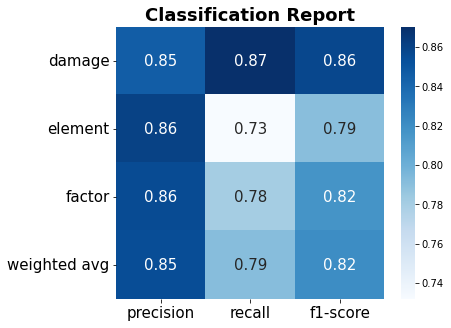

In [ ]:
# Classification Report 시각화

tag_values_l = [x.lower() for x in tag_values]
pred_tags_l = [x.lower() for x in pred_tags]
valid_tags_l = [x.lower() for x in valid_tags]

import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(pred_tags_l, valid_tags_l, labels = tag_values_l, output_dict=True)

plt.figure(figsize = (6,5))
sns.heatmap(pd.DataFrame(report).iloc[:-1, [0, 1, 2, 5]].T, annot=True, cmap='Blues', annot_kws={"size": 15})
plt.yticks(rotation=0, fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.title('Classification Report', weight='bold').set_fontsize('18')
plt.savefig('Classification Report.png')
plt.show()


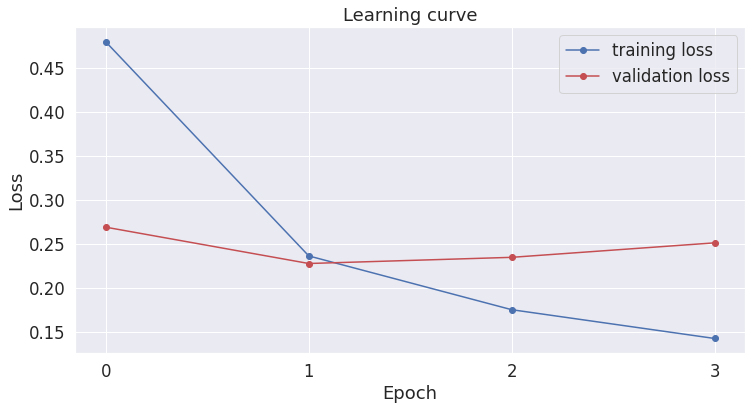

In [ ]:
# Learning Curve 확인

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.xticks(np.arange(0, 4, step=1))  # Set label locations.

plt.show()


In [ ]:
# 새로운 입력 문장 정의

# test_sentence = """
# 배수시설 점검시에는 배수구와 배수관의 파손, 누수 및 체수, 부식에 의한 구조물의 오염 여부를
# 점검한다. 또한 설계시 배수구의 위치를 잘못 설정하여 체수의 원인이 될 수 있으므로 이에 대한
# 점검도 필요하다.
# """

# test_sentence = """
# 보도부 또한 매우 양호한 외관 상태를 보이고 있는 것으로 관찰되었으며, 구배불량에 따른 체수 및 배수구 주변의 물고임 현상은 발생되지 않은 상태로 확인되었다.
# """

test_sentence = """
신축이음의 하부 누수로 인해 바닥판 및 교대부에 누수흔적 및 열화가 발생되고 있는 상태로 신축이음 및 표면손상부의 상태변화 여부에 대한 주의관찰 및 적절한 보수가 요구된다.
"""


In [ ]:
# 입력 문장에 대한 예측값 확인

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
tag_values = list(set(word_labels_flat))

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


None	[CLS]
ELEMENT	신축이음의
None	하부
FACTOR	누수로
None	인해
ELEMENT	바닥판
None	및
ELEMENT	교대부에
DAMAGE	누수흔적
None	및
DAMAGE	열화가
None	발생되고
None	있는
None	상태로
ELEMENT	신축이음
None	및
ELEMENT	표면손상부의
None	상태변화
None	여부에
None	대한
None	주의관찰
None	및
None	적절한
None	보수가
None	요구된다
None	.
None	[SEP]
